# Report Checkpoint

Brady Zhou, 
Raymond Zhao, 
and Lingpeng Meng

### Problem

A playing speaker is placed on a desk in a room. With a set of microphone arrays placed around the room, its location can be roughly triangulated given the resulting data collected by the arrays, processed using beamforming [1]. In our experiment, our 5 arrays each produce a 3D "vector" of arrival that tells the direction from which the array perceived the signal. From here, the goal becomes to transform this data from $\mathbb{R}^{15}$ to $\mathbb{R}^{3}$

There are several naive solutions here, but two stand out as particularly robust: PCA and linear mapping. PCA seems a natural fit; downsizing from $15 \to 3$ with no real interpretative significance on any particular variable. While surprisingly precise, PCA suffers from 2 large issues: PCA can't handle missing values and the arrays' data output can be inconsistent, and the final result is couched in the fitted PCA space, which is extremely difficult to map back to the real world.

Linear (or affine) mappings solve the issues of missing values and abstract spaces but still leave a little to be desired, since accuracy is then limited by the fact that it still only maps linear functions when clearly the underlying dynamics of a room are likely nonlinear. This in addition to the fact that they need to be very well calibrating on anchor points to work some things to be desired, so the aim then is to find models to address the problems above while minimizing tradeoffs in accuracy or practicality.

### Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')
from Mapping import *
sys.path.append('../src/prediction')
from PCA import *
from nn import *

import pickle
import matplotlib
import matplotlib.pyplot as plt

In [2]:
V5 = pickle.load(open('../data/V5.p','rb'))
cp_list = V5["cp_list"]
active_L_table_slide_DOA = V5["active_L_table_slide_DOA"]
active_L_table_slide_matrix = V5["active_L_table_slide_matrix"]
active_long_table_slide_DOA = V5["active_long_table_slide_DOA"]
active_long_table_slide_matrix = V5["active_long_table_slide_matrix"]

In [3]:
DOA_LIST = cp_list
ROOM_COORDINATES = ROOM_COORDINATES
TABLE_CP_IND = [0,1,2,3,4,5]
CHAIR_CP_IND = [6,7,8,9,10]
ALL_CP_IND   = [0,1,2,3,4,5,6,7,8,9,10]
L_TABLE_CP_IND = [0,1,2,3]
LONG_TABLE_CP_IND = [4,5]
DATA_IND = [TABLE_CP_IND,CHAIR_CP_IND,ALL_CP_IND]

R_1 = ROOM_COORDINATES[0,:2].T.reshape(-1,1)
D_1 = np.median(DOA_LIST[0], axis=0).reshape(-1,1)

# use cp6 to calculate displacement for long table slide
R_6 = ROOM_COORDINATES[5,:2].T.reshape(-1,1)
D_6 = np.median(DOA_LIST[5], axis=0).reshape(-1,1)

R_LIST = [R_1, R_6]
D_LIST = [D_1, D_6]

### Plots
Here are example plots of all three networks in action. The following plots show the path that the sound source travels. The path makes a semi-rectangular path as it moves from each corner of the table on the lower portion of the l-shaped table. On the long table, the sound soruce travels in a relatively straight line. What paths we are expected is a rectangle on the right and a line on the left. 

#### Affine Mapping Plot (the baseline)

([<matplotlib.axis.YTick at 0x2417a329358>,
 <a list of 5 Text yticklabel objects>)

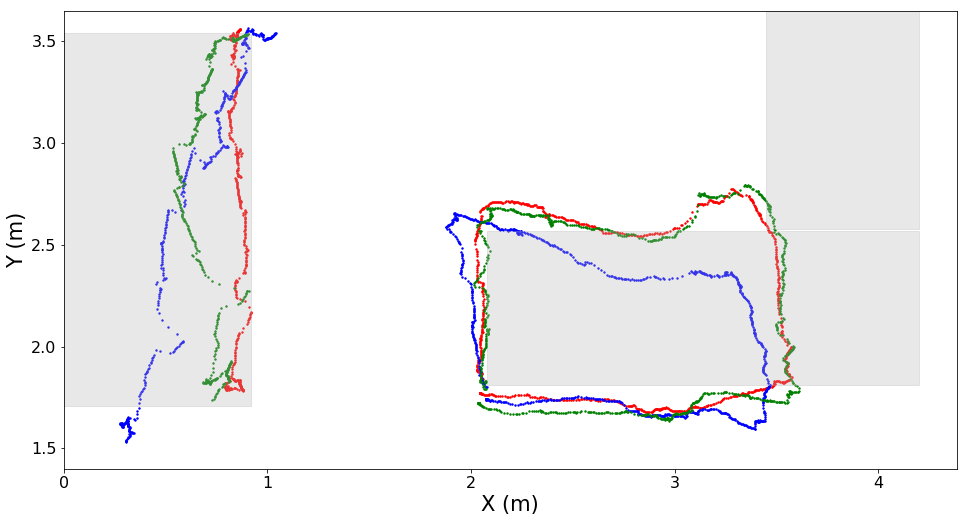

In [4]:
EVENT_DOA = [active_L_table_slide_DOA, active_long_table_slide_DOA]
EVENT_LABEL = ['L Table Slide', 'Long Table slide']
B_MATRIX_NAME = ['Table','Chair','All']
COLOR_LIST = ['r','b','g']
MARKER_LIST = ["$1$","$2$","$3$","$4$","$5$","$6$","$7$","$8$","$9$","$10$","$11$"]

fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

for ii in range(len(EVENT_DOA)):
    for jj in range(len(DATA_IND)):
        DOA_points = [DOA_LIST[IND] for IND in DATA_IND[jj]]
        room_coordinates = ROOM_COORDINATES[DATA_IND[jj],:]
        B,R_mean,D_mean,D = generate_linear_transform_matrix(DOA_points, room_coordinates, 2) 
        R_0 = R_LIST[ii]-B @ D_LIST[ii]
        r = R_0 +B @ EVENT_DOA[ii].T
        # only plot with label once
        if ii==0:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2) 
        else:
            ax.scatter(r[0,:], r[1,:], c=COLOR_LIST[jj], s=2, label=B_MATRIX_NAME[jj])    
ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  
# ax.scatter(ROOM_COORDINATES[:,0],ROOM_COORDINATES[:,1], c='k', s=30)
# ax.tick_params(axis='y', labelsize = 21, width = 2, length = 8)
# ax.tick_params(axis='x',labelsize = 21, width = 2, length = 8)

# for kk in range(ROOM_COORDINATES.shape[0]):
#     ax.scatter(ROOM_COORDINATES[kk,0]+0.2, ROOM_COORDINATES[kk,1], marker=MARKER_LIST[kk], s=200, c='k')
# ax.legend(markerscale=5,fontsize=15)
# plt.show()
# fig.savefig('Mappingtables.pdf', bbox_inches='tight', pad_inches=0)

#### Feedforward Neural Net
This feedforward neural network is the classic neural network architecture. The input shape is 15x3 while the output (in this use-case) is a 2-D coordinate. The hidden size is 20 and the number of epochs is 2. 

In [5]:
cp_torch = [torch.from_numpy(cp) for cp in cp_list[:4]]
room_coords = [torch.from_numpy(np.array([i[0], i[1]])) for i in ROOM_COORDINATES[:4]]
X = cp_torch
y = room_coords

In [6]:
model = NeuralNet(input_size, hidden_size, output_size)
model = model.float()

model.train(X, y)
predictions = model.predict(active_L_table_slide_DOA)

l_predictions = model.predict(active_long_table_slide_DOA)

([<matplotlib.axis.YTick at 0x2417a4b6898>,
 <a list of 5 Text yticklabel objects>)

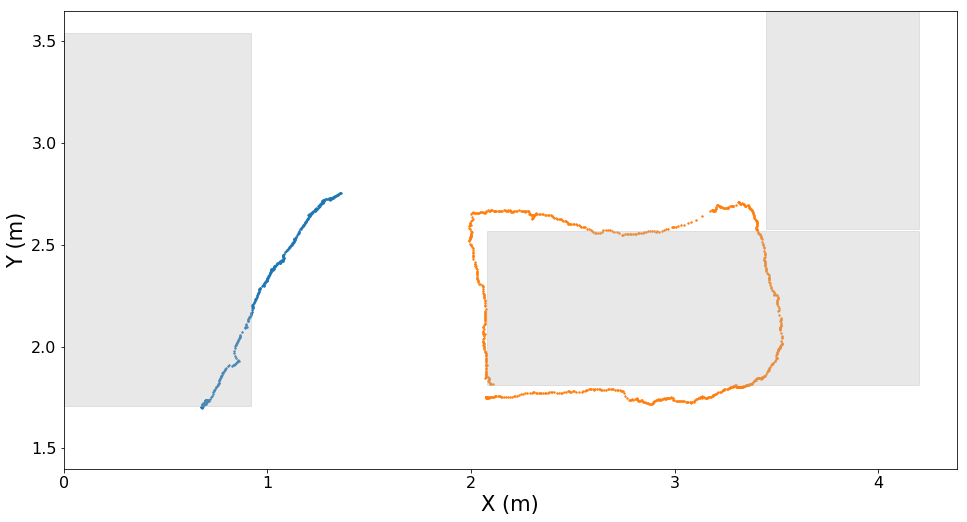

In [7]:
fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)

rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

# plot the path from the model
mapX = [x[0] for x in predictions]
mapy = [x[1] for x in predictions]
mapX_L = [x[0] for x in l_predictions]
mapy_L = [x[1] for x in l_predictions]

plt.scatter(mapX_L, mapy_L, s=2)
plt.scatter(mapX, mapy, s=2)

ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  

#### Support Vector Machine

In [8]:
control_points = cp_list[:4]
coordinates = [np.array([i[0], i[1]]) for i in ROOM_COORDINATES[:4]]
X = np.vstack([c for c in cp_list[:4]])
y = np.vstack([np.full([p.shape[0], len(c)], c) for p, c in zip(control_points, coordinates)])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

regr = MultiOutputRegressor(SVR(kernel='rbf', C=1e3, gamma=0.1))
regr.fit(X, y)

MultiOutputRegressor(estimator=SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=None)

([<matplotlib.axis.YTick at 0x2417be4d048>,
 <a list of 5 Text yticklabel objects>)

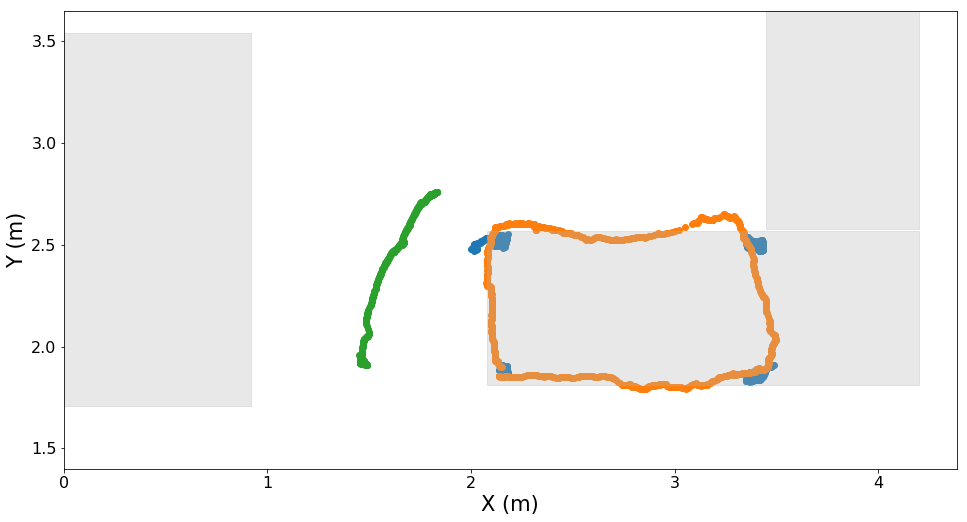

In [9]:
# plot the svm
fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)

rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

plt.scatter(*regr.predict(X).T)
plt.scatter(*regr.predict(active_L_table_slide_DOA).T)
plt.scatter(*regr.predict(active_long_table_slide_DOA).T)



ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  

#### SVM compared with Random Forest

('linear regression', <class 'sklearn.linear_model.base.LinearRegression'>)
('svr', <class 'sklearn.svm.classes.SVR'>)
('decision tree', <class 'sklearn.tree.tree.DecisionTreeRegressor'>)
('random forest', <class 'sklearn.ensemble.forest.RandomForestRegressor'>)


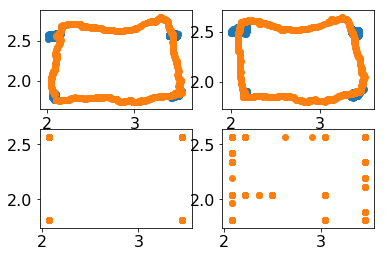

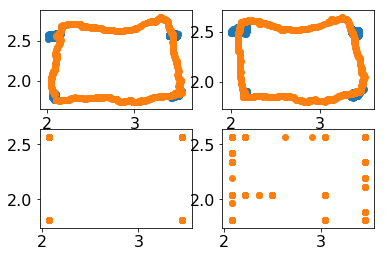

In [10]:
control_points = cp_list[:4]
coordinates = [np.array([i[0], i[1]]) for i in ROOM_COORDINATES[:4]]
X = np.vstack([c for c in cp_list[:4]])
y = np.vstack([np.full([p.shape[0], len(c)], c) for p, c in zip(control_points, coordinates)])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
models = {
    'linear regression': LinearRegression,
    'svr': SVR,
    'decision tree': DecisionTreeRegressor,
    'random forest': RandomForestRegressor
}
for m, ax in zip(models.items(), axes):
    print(m)
    model_name, model = m
    regr = MultiOutputRegressor(model())
    regr.fit(X, y)
    ax.scatter(*regr.predict(X).T)
    ax.scatter(*regr.predict(active_L_table_slide_DOA).T, label=model_name)
fig

#### Random Forest Plot on its own

([<matplotlib.axis.YTick at 0x2417b99d4a8>,
 <a list of 5 Text yticklabel objects>)

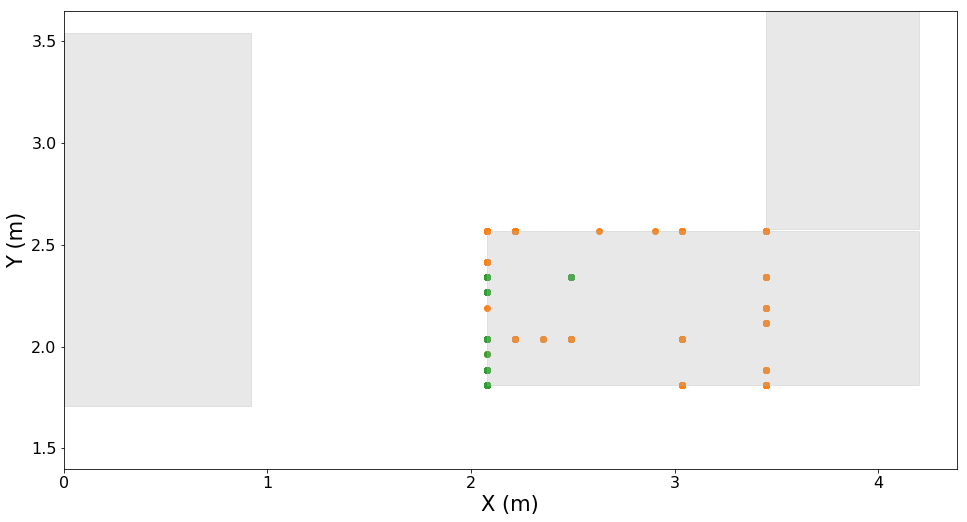

In [11]:
fig = plt.figure(figsize = [16,12])
plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(1,1,1)

rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_side_table = matplotlib.patches.Rectangle((0,1.71), 0.92, (3.54-1.71), alpha = 0.3, color = '0.7')
rect_main_table_1 = matplotlib.patches.Rectangle((2.08,1.81), (4.4-0.2-2.08), (2.57-1.81), alpha = 0.3, color = '0.7')
rect_main_table_2 = matplotlib.patches.Rectangle((3.45,2.58), (4.4-0.2-3.45), (3.54-2.595+0.2), alpha = 0.3, color = '0.7')

plt.scatter(*regr.predict(X).T)
plt.scatter(*regr.predict(active_L_table_slide_DOA).T)
plt.scatter(*regr.predict(active_long_table_slide_DOA).T)



ax.add_patch(rect_side_table)
ax.add_patch(rect_main_table_1)
ax.add_patch(rect_main_table_2)
ax.set_xlabel("X (m)", fontsize = 21)
ax.set_ylabel("Y (m)", fontsize = 21)
ax.set_aspect('equal')
ax.set(xlim=(0,4.385), ylim=(0,3.918))
ax.set(xlim=(0,4.385), ylim=(1.4,3.65))#ylim=(1.4,3.918))
plt.xticks([0, 1, 2, 3, 4])  
plt.yticks([1.5, 2,2.5, 3, 3.5])  

### References

[1] P. Gerstoft, Y. Hu, M. J. Bianco, C. Patil, A. Alegre, Y. Freund, F. Grondin “Audio scene monitoring using redundant ad-hoc microphone array networks”

[2] M. Hahmann, E. Fernandez-Grande, H. Gunawan, P. Gerstoft “Sound Source Localization in 3D Using Ad-Hoc Distributed Microphone Arrays”

[3] B. Zhou, R. Zhao, L. Meng "Interpreting Microphone Arrays with Machine Learning Methods"